# Analysis of Conveyed Emotions by Soft Robot in Smart Jewelry

In [1]:
seed = 48615548

## Importing Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Union
from arch.bootstrap import IIDBootstrap, IndependentSamplesBootstrap
from typing import Literal
from scipy.stats import mannwhitneyu
from matplotlib.ticker import MaxNLocator
import os.path

data_path = 'quantitative-results'
# data_path = 'pilot-results'
# data_path = 'pilot-results_shortened'
wide_data = pd.read_csv(data_path + '.csv', sep =";")
wide_data.rename(columns={"Group": "Material"}, inplace=True)
wide_data.tail()

Participant ID Material Location  Age Gender  Experience Soft-Robots  \
19              21        M        L   27      f                       3   
20              22        M        R   27      f                       1   
21              23        L        R   29      m                       1   
22              24        F        R   28      m                       1   
23              25        S        L   32      m                       3   

    Experience Smart Jewelry  V-T1  V-T2  V-UHF  ...  S-L  L-M  L-F  L-S  L-L  \
19                         3     4     2      4  ...    1    1    1    1    5   
20                         1     3     3      3  ...    1    4    5    5    2   
21                         1     4     3      3  ...    2    5    3    1    3   
22                         1     5     4      5  ...    1    2    4    2    5   
23                         1     3     4      5  ...    1    1    5    1    1   

    SU  SD  SW  ST  SE  
19   1   1   1   1   1  
20   1   1   1   0   0  
21   1   1   1   1   1  
22   1   1   1   1   0  
23   1   1   0   0   1  

[5 rows x 92 columns]

## Configuration

In [3]:
if not os.path.isdir("./data"):
        os.makedirs("./data")

orange = "#F7A600"
dark_blue = "#00549F"
light_blue = "#8EBBE5"
palette = {
    'Valence': dark_blue,
    'Arousal': orange,
}

hist_config = dict(binwidth=1, binrange=[1,5], discrete=True, shrink=0.9, kde=True, edgecolor=None)
ci_config = dict(join=False, n_boot=1000, dodge=0.2, seed=0, ci=95)
ci_between_config = dict(join=False, n_boot=None, dodge=0.2, ci=95)

## Functions

In [4]:
def confidence_interval(data: pd.DataFrame, value_vars: list[str], value_name:str, level_name: str, color, xlim=(1,5)):
    melted_data = pd.melt(data, id_vars=["Participant ID", "Material"], value_vars=value_vars)
    axes = []
    levels = []
    for index, row in melted_data.iterrows():
        axis = "Arousal" if row['variable'][0:1] == "A" else "Valence"
        axes.append(axis)
        level = row['variable'][2:]
        levels.append(level)
    melted_data["Axis"] = axes
    melted_data[level_name] = levels
    melted_data.rename(columns={"value": value_name}, inplace=True)
    g = sns.pointplot(data=melted_data, x=value_name, y=level_name, **ci_config, palette=[color])
    g.set(xlim=xlim)
    # 95% CIs

In [5]:
def bootstrapping(data: pd.DataFrame, iv: str, dv: Literal["V", "A"], method="bca"):
    random_state = np.random.RandomState(seed)
    bootstrapper = IIDBootstrap(data, random_state=random_state)
    ci = bootstrapper.conf_int(func=pd.DataFrame.mean, reps=1000, method=method)
    ci = pd.DataFrame(ci).transpose()
    ci["Mean"] = data.mean().tolist()
    columns_dict = {index: name[name.index(f"{dv}-")+2:] for index, name in enumerate(data.columns)}
    ci.rename(index=columns_dict, columns={0: "Lower", 1: "Upper"}, inplace=True)
    ci = ci.reindex(columns=["Mean", "Lower", "Upper"])
    dimension_strings={"V": "Valence", "A": "Arousal"}
    ci.style.set_caption(f"{iv} | {dimension_strings[dv]}")
    ci = ci.round(3)
    return ci

In [6]:
def bootstrapping_between(data: pd.DataFrame, iv: str, dv: Literal["V", "A"], group: str):
    data = data.pivot(columns=group)[f"Mean-{dv}-{iv}"]
    cis = pd.DataFrame()
    for [label,level] in data.iteritems():
        bootstrapper = IndependentSamplesBootstrap(level.dropna().values)
        ci = bootstrapper.conf_int(func=np.mean, reps=1000, method='basic')
        cis[label] = pd.Series([ci[0][0], ci[1][0]])
    cis = pd.DataFrame(cis).transpose()
    cis["Mean"] = data.mean().tolist()
    cis.rename(columns={0: "Lower", 1: "Upper"}, inplace=True)
    cis = cis.reindex(columns=["Mean", "Lower", "Upper"])
    dimension_strings={"V": "Valence", "A": "Arousal"}
    cis.style.set_caption(f"{iv} | {dimension_strings[dv]}")
    cis = cis.round(3)
    return cis

In [7]:
def win_columns(levels: list[str], dv: Literal["V", "A"]):
    columns = []
    for firstLevel in levels:
        for secondLevel in levels:
            if(firstLevel == secondLevel):
                continue
            columns.append(f"Win-{dv}-{firstLevel}-{secondLevel}")
    return columns

In [8]:
def between_pos(data:pd.DataFrame):
    statistics, _ = mannwhitneyu(data[0], data[1])
    return statistics / (len(data[0]) * len(data[1]))

def bootstrapping_pos_between(data: pd.DataFrame, first_level: str, second_level: str):
    first_level_vals = data[first_level].dropna().tolist()
    second_level_vals = data[second_level].dropna().tolist()
    df = pd.DataFrame({0: first_level_vals, 1: second_level_vals})
    bootstrapper = IIDBootstrap(df)
    ci = bootstrapper.conf_int(func=between_pos, reps=1000, method='basic')
    ci = pd.DataFrame(ci).transpose()
    ci["PS"] = between_pos(df)
    ci.rename(index={0: f"{first_level}-{second_level}"}, columns={0: "Lower", 1: "Upper"}, inplace=True)
    ci = ci.reindex(columns=["PS", "Lower", "Upper"])
    ci = ci.round(3)
    return ci

In [9]:
# Set x interval with MaxNLocator from Wacker et al. https://hci.rwth-aachen.de/heatmaps
# Capstyle: https://stackoverflow.com/questions/40292875/change-capstyle-for-errorbars-in-matplotlib

def plot_cis(data: pd.DataFrame, point_estimate = "Mean", filename= "plot", format="pdf", xLabel=None, title= None, showLineAtZero = False, showOnlyIntegers=True, xlim=None, color=dark_blue):
    categories = data.index.values
    height = 0.45 * len(data)
    fig, ax = plt.subplots(figsize=(6, height))
    pe = data[point_estimate]
    ci = [pe - data['Lower'], data['Upper'] - pe]
    plotline, caps, barlinecols = ax.errorbar(pe, categories, fmt='o', xerr=ci, elinewidth=3, capsize=0, color=color, ms=8, mec='w', mew=2)
    plt.setp(barlinecols, capstyle="round")
    fig.suptitle(title)
    ax.set_xlim(xlim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.tick_params(left=False)
    plt.tick_params()
    ax.set_ylim(-0.5,len(data)-0.5)
    ax.invert_yaxis()
    # ax.set_ylim(-0.1, len(data) - 0.9)
    output_folder = "./plots/"
    file_path = f"{output_folder}{filename}.{format}"
    if not os.path.isdir(output_folder):
        os.makedirs(output_folder)
    plt.xlabel(xLabel)
    if showOnlyIntegers:
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    if showLineAtZero:
        ax.axvline(x=0, color='k', linewidth=1)   
    
    plt.savefig(file_path, transparent=True, bbox_inches='tight', pad_inches=0.125, format=format)
    plt.show()
    plt.clf()

## Descriptive Analysis

In [10]:
description = wide_data.describe()
description

Participant ID        Age  Experience Soft-Robots  \
count       24.000000  24.000000               24.000000   
mean        13.500000  29.208333                2.041667   
std          7.071068  10.133797                1.232853   
min          2.000000  14.000000                1.000000   
25%          7.750000  23.000000                1.000000   
50%         13.500000  27.000000                1.000000   
75%         19.250000  29.750000                3.000000   
max         25.000000  59.000000                4.000000   

       Experience Smart Jewelry       V-T1       V-T2      V-UHF      V-UHH  \
count                 24.000000  24.000000  24.000000  24.000000  24.000000   
mean                   1.833333   3.041667   3.791667   4.083333   3.750000   
std                    1.203859   0.806450   1.141287   0.829702   0.793999   
min                    1.000000   2.000000   1.000000   2.000000   2.000000   
25%                    1.000000   2.750000   3.000000   4.000000   3.000000   
50%                    1.000000   3.000000   4.000000   4.000000   4.000000   
75%                    3.000000   3.250000   5.000000   5.000000   4.000000   
max                    4.000000   5.000000   5.000000   5.000000   5.000000   

           V-ULF      V-ULH  ...        S-L        L-M        L-F        L-S  \
count  24.000000  24.000000  ...  24.000000  24.000000  24.000000  24.000000   
mean    4.083333   3.500000  ...   1.166667   1.583333   2.750000   2.291667   
std     0.775532   0.780189  ...   0.481543   1.138904   1.390965   1.366658   
min     3.000000   2.000000  ...   1.000000   1.000000   1.000000   1.000000   
25%     3.750000   3.000000  ...   1.000000   1.000000   1.750000   1.000000   
50%     4.000000   3.500000  ...   1.000000   1.000000   3.000000   2.000000   
75%     5.000000   4.000000  ...   1.000000   2.000000   4.000000   3.000000   
max     5.000000   5.000000  ...   3.000000   5.000000   5.000000   5.000000   

             L-L         SU    SD         SW         ST         SE  
count  24.000000  24.000000  24.0  24.000000  24.000000  24.000000  
mean    4.541667   0.916667   1.0   0.791667   0.791667   0.791667  
std     1.062367   0.282330   0.0   0.414851   0.414851   0.414851  
min     1.000000   0.000000   1.0   0.000000   0.000000   0.000000  
25%     5.000000   1.000000   1.0   1.000000   1.000000   1.000000  
50%     5.000000   1.000000   1.0   1.000000   1.000000   1.000000  
75%     5.000000   1.000000   1.0   1.000000   1.000000   1.000000  
max     5.000000   1.000000   1.0   1.000000   1.000000   1.000000  

[8 rows x 89 columns]

In [11]:
participants = wide_data[["Age", "Gender", "Experience Soft-Robots", "Experience Smart Jewelry"]]
participants.describe()

Age  Experience Soft-Robots  Experience Smart Jewelry
count  24.000000               24.000000                 24.000000
mean   29.208333                2.041667                  1.833333
std    10.133797                1.232853                  1.203859
min    14.000000                1.000000                  1.000000
25%    23.000000                1.000000                  1.000000
50%    27.000000                1.000000                  1.000000
75%    29.750000                3.000000                  3.000000
max    59.000000                4.000000                  4.000000

### Age

<AxesSubplot:ylabel='Frequency'>

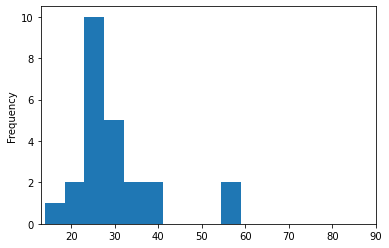

In [12]:
participants["Age"].plot.hist(xlim=(13, 90))

### Prior Knowledge

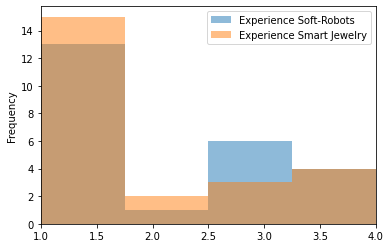

In [13]:
experience_plot = participants[["Experience Soft-Robots", "Experience Smart Jewelry"]].plot.hist(bins=4, xlim=(1,4), alpha=0.5)

### Transforming Data to long format

In [14]:
arousal = pd.melt(wide_data.reset_index(), id_vars=['Participant ID', 'Material'], value_vars=["A-UHF","A-UHH","A-ULF","A-ULH","A-UNF","A-UNH","A-DHF","A-DHH","A-DLF","A-DLH","A-DNF","A-DNH","A-WHF","A-WHH","A-WLF","A-WLH","A-WNF","A-WNH","A-THF","A-THH","A-TLF","A-TLH","A-TNF","A-TNH","A-EHF","A-EHH","A-ELF","A-ELH","A-ENF","A-ENH"])
arousal.rename(columns={"variable": "Arousal Trial", "value": "Arousal"}, inplace=True)
shapes = []
frequencies = []
amplitudes = []
for index, row in arousal.iterrows():
    shape = row['Arousal Trial'][2:3]
    shapes.append(shape)
    frequency = row['Arousal Trial'][3:4]
    frequencies.append(frequency)
    amplitude = row['Arousal Trial'][4:5]
    amplitudes.append(amplitude)
arousal['Shape'] = shapes
arousal['Frequency'] = frequencies
arousal['Amplitude'] = amplitudes
arousal = arousal.reindex(columns=["Participant ID", "Material", "Shape", "Frequency", "Amplitude", "Arousal"])

valence = pd.melt(wide_data.reset_index(), id_vars=['Participant ID', 'Material'], value_vars=["V-UHF","V-UHH","V-ULF","V-ULH","V-UNF","V-UNH","V-DHF","V-DHH","V-DLF","V-DLH","V-DNF","V-DNH","V-WHF","V-WHH","V-WLF","V-WLH","V-WNF","V-WNH","V-THF","V-THH","V-TLF","V-TLH","V-TNF","V-TNH","V-EHF","V-EHH","V-ELF","V-ELH","V-ENF","V-ENH"])
valence.rename(columns={"variable": "Valence Trial", "value": "Valence"}, inplace=True)
shapes = []
frequencies = []
amplitudes = []
for index, row in valence.iterrows():
    shape = row['Valence Trial'][2:3]
    shapes.append(shape)
    frequency = row['Valence Trial'][3:4]
    frequencies.append(frequency)
    amplitude = row['Valence Trial'][4:5]
    amplitudes.append(amplitude)
valence['Shape'] = shapes
valence['Frequency'] = frequencies
valence['Amplitude'] = amplitudes
valence = valence.reindex(columns=["Participant ID", "Material", "Shape", "Frequency", "Amplitude", "Valence"])

long_data = arousal.merge(valence, on=["Participant ID", "Material", "Shape", "Frequency", "Amplitude"])
long_data.sort_values(by=["Participant ID", "Material", "Shape", "Frequency"], inplace=True)
long_data.reindex(columns=["Participant ID", "Material", "Shape", "Frequency", "Amplitude", "Arousal", "Valence"])
long_data.reset_index(inplace=True)
long_data.to_csv(data_path+'_long.csv')
long_data

index  Participant ID Material Shape Frequency Amplitude  Arousal  \
0      144               2        M     D         H         F        2   
1      168               2        M     D         H         H        4   
2      192               2        M     D         L         F        4   
3      216               2        M     D         L         H        1   
4      240               2        M     D         N         F        5   
..     ...             ...      ...   ...       ...       ...      ...   
715    335              25        S     W         H         H        4   
716    359              25        S     W         L         F        3   
717    383              25        S     W         L         H        1   
718    407              25        S     W         N         F        4   
719    431              25        S     W         N         H        3   

     Valence  
0          2  
1          2  
2          2  
3          3  
4          1  
..       ...  
715        3  
716        3  
717        3  
718        3  
719        4  

[720 rows x 8 columns]

In [15]:
descr_material = long_data.groupby(['Shape'], as_index=False).agg({'Arousal':['mean','std'],'Valence':['mean','std'],})
descr_material

Shape   Arousal             Valence          
             mean       std      mean       std
0     D  3.069444  1.209824  1.909722  0.892182
1     E  3.173611  1.154680  3.055556  0.859157
2     T  3.166667  1.251572  3.048611  0.910927
3     U  3.118056  1.231842  3.833333  0.877058
4     W  3.631944  1.192908  3.618056  0.946074

In [16]:
descr_material = long_data.groupby(['Frequency'], as_index=False).agg({'Arousal':['mean','std'],'Valence':['mean','std'],})
descr_material

Frequency   Arousal             Valence          
                 mean       std      mean       std
0         H  3.683333  1.101413  3.245833  1.125021
1         L  2.895833  1.217714  3.062500  1.082502
2         N  3.116667  1.211406  2.970833  1.129290

In [17]:
descr_material = long_data.groupby(['Amplitude'], as_index=False).agg({'Arousal':['mean','std'],'Valence':['mean','std'],})
descr_material

Amplitude   Arousal             Valence          
                 mean       std      mean       std
0         F  3.555556  1.176474  3.172222  1.221126
1         H  2.908333  1.182480  3.013889  0.997114

### Boxplot Materiality Check

In [18]:
#TODO

### Boxplot Material x Arousal

<AxesSubplot:xlabel='Material', ylabel='Arousal'>

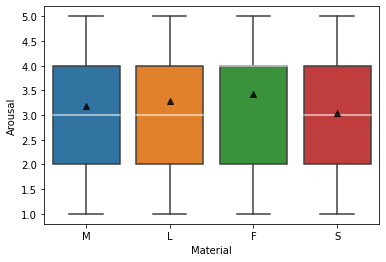

In [19]:

material_boxplot = sns.boxplot(x='Material', y='Arousal', data=long_data, medianprops=dict(color="white", alpha=0.7), showmeans=True, meanprops=dict(markerfacecolor="black", markeredgecolor="black", alpha=0.8))
material_boxplot

### Boxplot Shape x Arousal

<AxesSubplot:xlabel='Shape', ylabel='Arousal'>

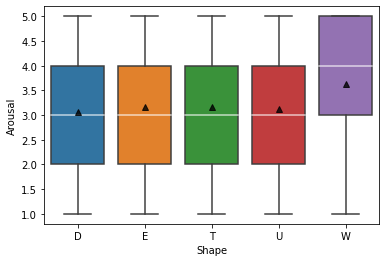

In [20]:
shape_boxplot = sns.boxplot(x='Shape', y='Arousal', data=long_data, medianprops=dict(color="white", alpha=0.7), showmeans=True, meanprops=dict(markerfacecolor="black", markeredgecolor="black", alpha=0.8))
shape_boxplot

### Boxplot Frequency x Arousal

<AxesSubplot:xlabel='Frequency', ylabel='Arousal'>

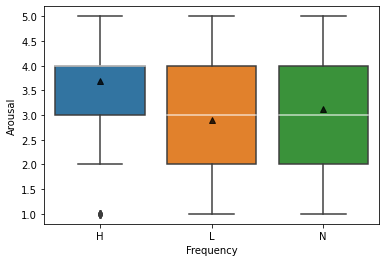

In [21]:
frequency_boxplot = sns.boxplot(x='Frequency', y='Arousal', data=long_data, medianprops=dict(color="white", alpha=0.7), showmeans=True, meanprops=dict(markerfacecolor="black", markeredgecolor="black", alpha=0.8))
frequency_boxplot

### Boxplot Amplitude x Arousal

<AxesSubplot:xlabel='Amplitude', ylabel='Arousal'>

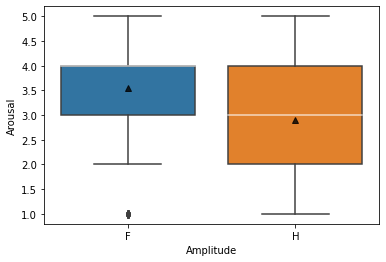

In [22]:
amplitude_boxplot = sns.boxplot(x='Amplitude', y='Arousal', data=long_data, medianprops=dict(color="white", alpha=0.7), showmeans=True, meanprops=dict(markerfacecolor="black", markeredgecolor="black", alpha=0.8))
amplitude_boxplot

### Distribution

Distribution of Valance and Arousal by **Shape**, **Frequency** and **Amplitude** (but *not* **Materiality**)

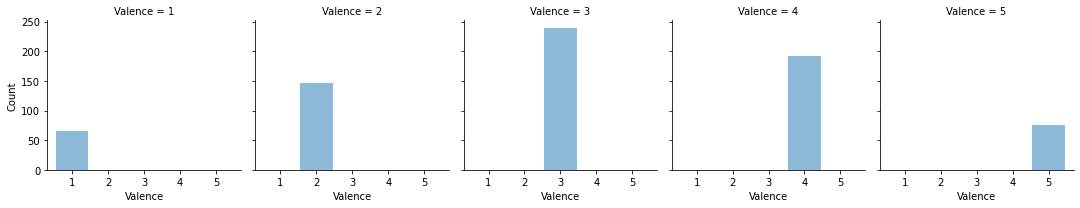

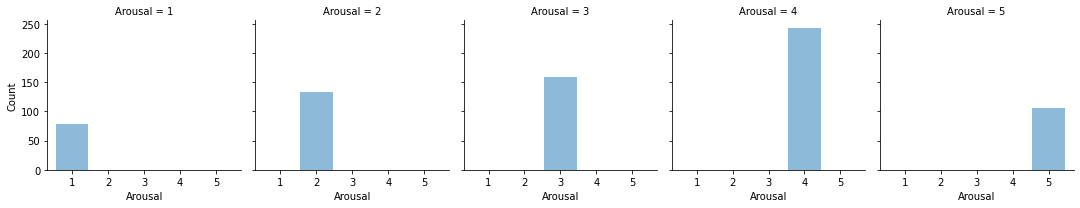

In [23]:
g = sns.FacetGrid(long_data, col="Valence", col_wrap=6)
g.map(sns.histplot, "Valence", **hist_config)

g = sns.FacetGrid(long_data, col="Arousal", col_wrap=6)
g.map(sns.histplot, "Arousal", **hist_config)

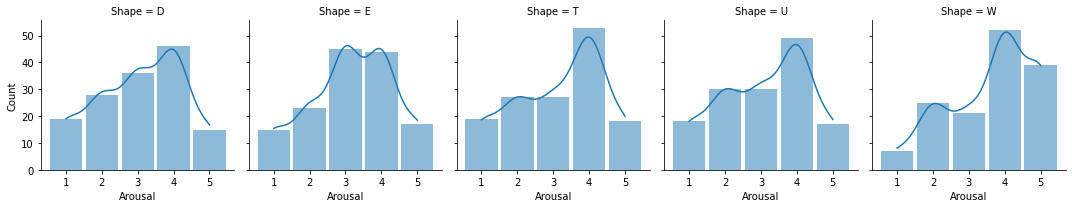

In [24]:
g = sns.FacetGrid(long_data, col="Shape")
g.map(sns.histplot, "Arousal", **hist_config)

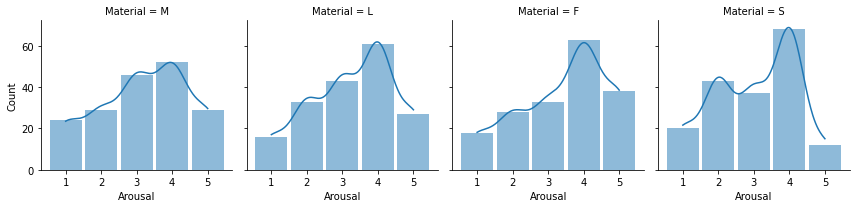

In [25]:
g = sns.FacetGrid(long_data, col="Material")
g.map(sns.histplot, "Arousal", **hist_config)

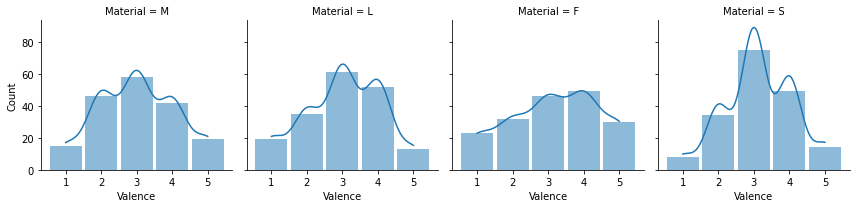

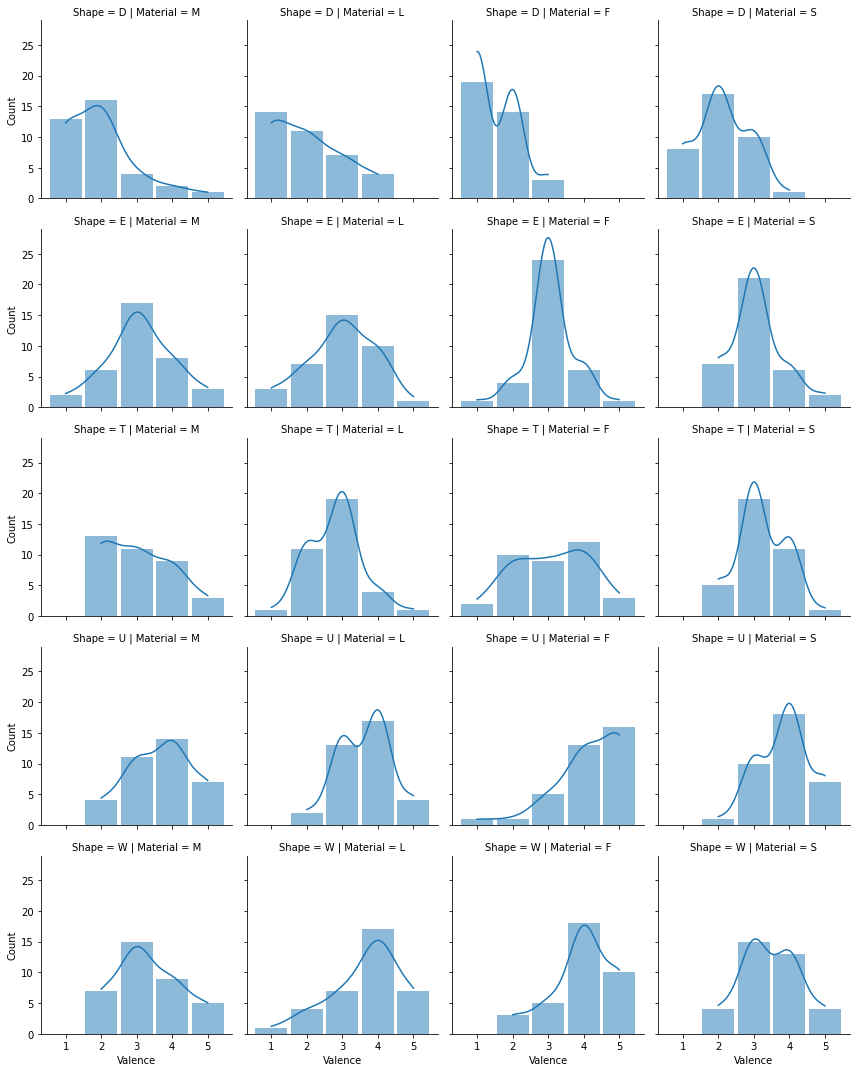

In [26]:

f = sns.FacetGrid(long_data, col="Material")
f.map(sns.histplot, "Valence", **hist_config)

h = sns.FacetGrid(long_data, col="Material", row="Shape")
h.map(sns.histplot, "Valence", **hist_config)

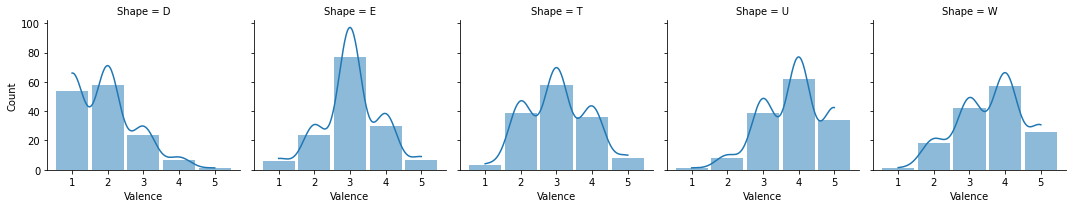

In [27]:
g = sns.FacetGrid(long_data, col="Shape")
g.map(sns.histplot, "Valence", **hist_config)

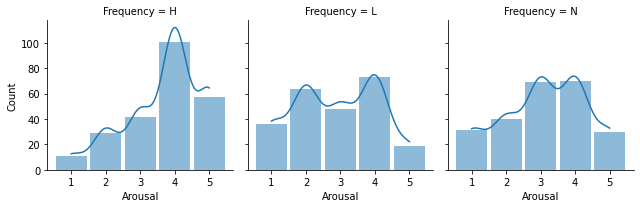

In [28]:
g = sns.FacetGrid(long_data, col="Frequency")
g.map(sns.histplot, "Arousal", **hist_config)

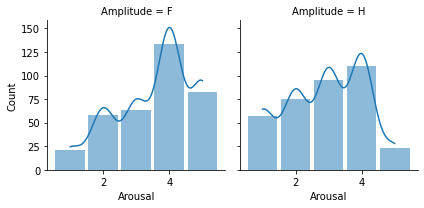

In [29]:
g = sns.FacetGrid(long_data, col="Amplitude")
g.map(sns.histplot, "Arousal", **hist_config)

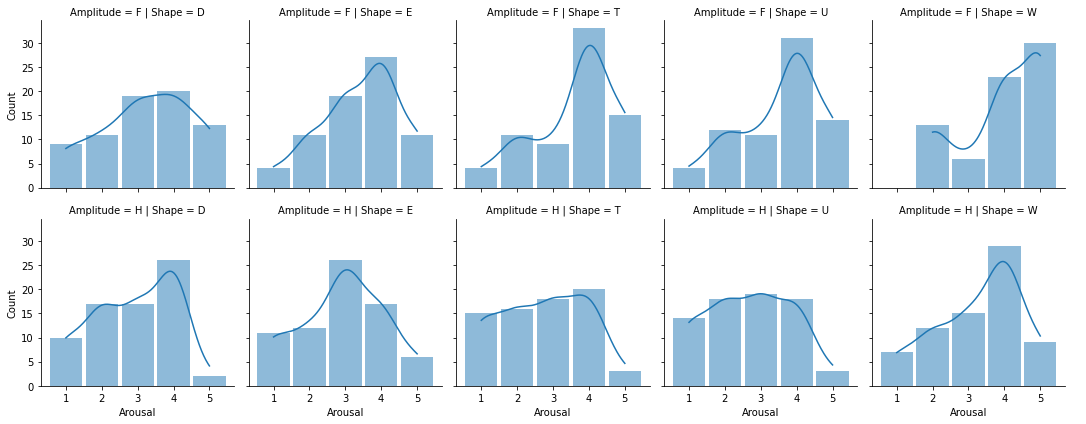

In [30]:
g = sns.FacetGrid(long_data, col="Shape", row="Amplitude", height=3)
histogram_colors = dict(linewidth=0)
g.map(sns.histplot, "Arousal", **hist_config)
g.add_legend()

## Manipulations Checks

### Shapes

In [84]:
columns = ["SU", "SD", "SW", "ST", "SE"]
columns_names = ["Up", "Down", "Wave", "Twist", "Elongate"]
recognized_shapes_data = wide_data[columns]
random_state = np.random.RandomState(seed)
bootstrapper = IIDBootstrap(recognized_shapes_data, random_state=random_state)
regognized_shapes_cis = bootstrapper.conf_int(func=pd.DataFrame.mean, reps=1000)
regognized_shapes_cis = pd.DataFrame(regognized_shapes_cis).transpose()
regognized_shapes_cis["Mean"] = recognized_shapes_data.mean().tolist()
columns_dict = {index: columns_names[index] for index, _ in enumerate(recognized_shapes_data.columns)}
regognized_shapes_cis.rename(index=columns_dict, columns={0: "Lower", 1: "Upper"}, inplace=True)
regognized_shapes_cis = regognized_shapes_cis.reindex(columns=["Mean", "Lower", "Upper"])
regognized_shapes_cis.style.set_caption(f"Shape | Percentage recognized")
regognized_shapes_cis = regognized_shapes_cis.round(3)
regognized_shapes_cis = regognized_shapes_cis.clip(lower=0, upper=1)
regognized_shapes_cis.to_csv("data/regognized_shapes_cis.csv")
regognized_shapes_cis

/Users/soeren/opt/anaconda3/lib/python3.9/site-packages/arch/bootstrap/base.py:411: FutureWarning: random_state is deprecated and will be removed in a future version. The default random number generator is changing to a NumPy Generator. To continue using RandomState, please directly pass a RandomState instance using the ``generator`` keyword argument.
  warnings.warn(


Mean  Lower  Upper
Up        0.917  0.833  1.000
Down      1.000  1.000  1.000
Wave      0.792  0.667  0.958
Twist     0.792  0.625  0.958
Elongate  0.792  0.625  0.958

bca wasn't possible since every participant remembered the down shape
CIs had to be clipped to 1 for upper since the upper estimate exceeded 100%

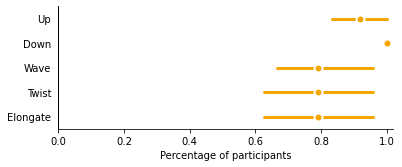

<Figure size 432x288 with 0 Axes>

In [83]:
plot_cis(
    regognized_shapes_cis,
    point_estimate="Mean",
    filename="regognized_shapes_cis",
    format='pdf',
    xLabel='Percentage of participants',
    showOnlyIntegers=False,
    color=orange,
    xlim=(0,None),
    showLineAtZero=True)

### Material


In [87]:
wide_data
materials = ["M", "F", "S", "L"]
material_names = ["Metal", "Fabric", "Silicone", "Leather"]
columns = []
for first_material in materials:
    for second_material in materials:
        columns.append(f"{second_material}-{first_material}")
material_ratings = wide_data[columns]
material_ratings

random_state = np.random.RandomState(seed)
bootstrapper = IIDBootstrap(material_ratings, random_state=random_state)
material_ratings_cis = bootstrapper.conf_int(func=pd.DataFrame.mean, reps=1000)
material_ratings_cis = pd.DataFrame(material_ratings_cis).transpose()
material_ratings_cis["Mean"] = material_ratings.mean().tolist()
columns_dict = {index: name for index, name in enumerate(material_ratings.columns)}
material_ratings_cis.rename(index=columns_dict, columns={0: "Lower", 1: "Upper"}, inplace=True)
material_ratings_cis = material_ratings_cis.reindex(columns=["Mean", "Lower", "Upper"])
material_ratings_cis.style.set_caption(f"Shape | Percentage recognized")
material_ratings_cis = material_ratings_cis.round(3)
material_ratings_cis.to_csv("data/material_ratings_cis.csv")
material_ratings_cis

/Users/soeren/opt/anaconda3/lib/python3.9/site-packages/arch/bootstrap/base.py:411: FutureWarning: random_state is deprecated and will be removed in a future version. The default random number generator is changing to a NumPy Generator. To continue using RandomState, please directly pass a RandomState instance using the ``generator`` keyword argument.
  warnings.warn(


Mean  Lower  Upper
M-M  4.333  4.000  4.708
F-M  1.667  1.250  2.043
S-M  3.542  2.958  4.042
L-M  1.583  1.083  1.959
M-F  2.667  2.082  3.292
F-F  4.750  4.542  5.042
S-F  1.792  1.292  2.208
L-F  2.750  2.250  3.292
M-S  1.583  1.125  1.917
F-S  1.583  1.208  1.917
S-S  3.792  3.208  4.417
L-S  2.292  1.708  2.792
M-L  2.083  1.542  2.625
F-L  1.417  1.082  1.708
S-L  1.167  0.958  1.333
L-L  4.542  4.167  5.000

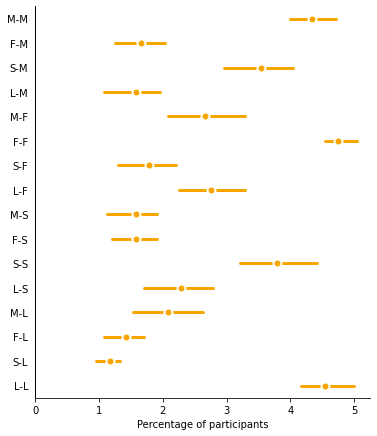

<Figure size 432x288 with 0 Axes>

In [82]:
plot_cis(
    material_cis,
    point_estimate="Mean",
    filename="material_ratings_cis",
    format='pdf',
    xLabel='Percentage of participants',
    showOnlyIntegers=False,
    color=orange,
    xlim=(0,None),
    showLineAtZero=True)

## Inferential Analysis

### Data Preperation

#### Calculating Means

In [31]:
wide_data["Mean-V-Material"] = wide_data.filter(regex="^V-...").mean(axis=1)
wide_data["Mean-A-Material"] = wide_data.filter(regex="^A-...").mean(axis=1)

wide_data["Mean-A-Up"] = wide_data.filter(regex="^A-U..").mean(axis=1)
wide_data["Mean-A-Down"] = wide_data.filter(regex="^A-D..").mean(axis=1)
wide_data["Mean-A-Wave"] = wide_data.filter(regex="^A-W..").mean(axis=1)
wide_data["Mean-A-Twist"] = wide_data.filter(regex="^A-T..").mean(axis=1)
wide_data["Mean-A-Elongate"] = wide_data.filter(regex="^A-E..").mean(axis=1)
wide_data["Mean-V-Up"] = wide_data.filter(regex="^V-U..").mean(axis=1)
wide_data["Mean-V-Down"] = wide_data.filter(regex="^V-D..").mean(axis=1)
wide_data["Mean-V-Wave"] = wide_data.filter(regex="^V-W..").mean(axis=1)
wide_data["Mean-V-Twist"] = wide_data.filter(regex="^V-T..").mean(axis=1)
wide_data["Mean-V-Elongate"] = wide_data.filter(regex="^V-E..").mean(axis=1)


wide_data["Mean-A-High"] = wide_data.filter(regex="^A-.H.").mean(axis=1)
wide_data["Mean-A-Low"] = wide_data.filter(regex="^A-.L.").mean(axis=1)
wide_data["Mean-A-None"] = wide_data.filter(regex="^A-.N.").mean(axis=1)
wide_data["Mean-V-High"] = wide_data.filter(regex="^V-.H.").mean(axis=1)
wide_data["Mean-V-Low"] = wide_data.filter(regex="^V-.L.").mean(axis=1)
wide_data["Mean-V-None"] = wide_data.filter(regex="^V-.N.").mean(axis=1)


wide_data["Mean-A-Up-Full"] = wide_data.filter(regex="^A-U.F").mean(axis=1)
wide_data["Mean-A-Up-Half"] = wide_data.filter(regex="^A-U.H").mean(axis=1)

wide_data["Mean-A-Down-Full"] = wide_data.filter(regex="^A-D.F").mean(axis=1)
wide_data["Mean-A-Down-Half"] = wide_data.filter(regex="^A-D.H").mean(axis=1)

wide_data["Mean-A-Wave-Full"] = wide_data.filter(regex="^A-W.F").mean(axis=1)
wide_data["Mean-A-Wave-Half"] = wide_data.filter(regex="^A-W.H").mean(axis=1)

wide_data["Mean-A-Twist-Full"] = wide_data.filter(regex="^A-T.F").mean(axis=1)
wide_data["Mean-A-Twist-Half"] = wide_data.filter(regex="^A-T.H").mean(axis=1)

wide_data["Mean-A-Elongate-Full"] = wide_data.filter(regex="^A-E.F").mean(axis=1)
wide_data["Mean-A-Elongate-Half"] = wide_data.filter(regex="^A-E.H").mean(axis=1)


wide_data["Mean-A-Up-None"] = wide_data.filter(regex="^A-UN.").mean(axis=1)
wide_data["Mean-A-Up-Low"] = wide_data.filter(regex="^A-UL.").mean(axis=1)
wide_data["Mean-A-Up-High"] = wide_data.filter(regex="^A-UH.").mean(axis=1)

wide_data["Mean-A-Down-None"] = wide_data.filter(regex="^A-DN.").mean(axis=1)
wide_data["Mean-A-Down-Low"] = wide_data.filter(regex="^A-DL.").mean(axis=1)
wide_data["Mean-A-Down-High"] = wide_data.filter(regex="^A-DH.").mean(axis=1)

wide_data["Mean-A-Wave-None"] = wide_data.filter(regex="^A-WN.").mean(axis=1)
wide_data["Mean-A-Wave-Low"] = wide_data.filter(regex="^A-WL.").mean(axis=1)
wide_data["Mean-A-Wave-High"] = wide_data.filter(regex="^A-WH.").mean(axis=1)

wide_data["Mean-A-Twist-None"] = wide_data.filter(regex="^A-TN.").mean(axis=1)
wide_data["Mean-A-Twist-Low"] = wide_data.filter(regex="^A-TL.").mean(axis=1)
wide_data["Mean-A-Twist-High"] = wide_data.filter(regex="^A-TH.").mean(axis=1)

wide_data["Mean-A-Elongate-None"] = wide_data.filter(regex="^A-EN.").mean(axis=1)
wide_data["Mean-A-Elongate-Low"] = wide_data.filter(regex="^A-EL.").mean(axis=1)
wide_data["Mean-A-Elongate-High"] = wide_data.filter(regex="^A-EH.").mean(axis=1)


#### Means of Differences (per Participant)

##### Shape

In [32]:
diffDownUpV = pd.DataFrame()
diffWaveUpV = pd.DataFrame()
diffElongateUpV = pd.DataFrame()
diffTwistUpV = pd.DataFrame()
diffDownWave = pd.DataFrame()
diffDownElongateV = pd.DataFrame()
diffDownTwistV = pd.DataFrame()
diffElongateWaveV = pd.DataFrame()
diffTwistWaveV = pd.DataFrame()
diffTwistElongateV = pd.DataFrame()
shapeKeys = ["U", "D", "W", "E", "T"]
frequencyKeys = ["H", "L", "N"]
amplitudeKeys = ["F", "H"]

for frequencyKey in frequencyKeys:
    for amplitudeKey in amplitudeKeys:
        diffDownUpV[f"{frequencyKey}{amplitudeKey}"] = wide_data[f"V-U{frequencyKey}{amplitudeKey}"]  - wide_data[f"V-D{frequencyKey}{amplitudeKey}"]
        diffWaveUpV[f"{frequencyKey}{amplitudeKey}"] = wide_data[f"V-U{frequencyKey}{amplitudeKey}"]  - wide_data[f"V-W{frequencyKey}{amplitudeKey}"]
        diffElongateUpV[f"{frequencyKey}{amplitudeKey}"] = wide_data[f"V-U{frequencyKey}{amplitudeKey}"]  - wide_data[f"V-E{frequencyKey}{amplitudeKey}"]
        diffTwistUpV[f"{frequencyKey}{amplitudeKey}"] = wide_data[f"V-U{frequencyKey}{amplitudeKey}"]  - wide_data[f"V-T{frequencyKey}{amplitudeKey}"]
        diffDownWave[f"{frequencyKey}{amplitudeKey}"] = wide_data[f"V-W{frequencyKey}{amplitudeKey}"] - wide_data[f"V-D{frequencyKey}{amplitudeKey}"]
        diffDownElongateV[f"{frequencyKey}{amplitudeKey}"] = wide_data[f"V-E{frequencyKey}{amplitudeKey}"] - wide_data[f"V-D{frequencyKey}{amplitudeKey}"]
        diffDownTwistV[f"{frequencyKey}{amplitudeKey}"] = wide_data[f"V-T{frequencyKey}{amplitudeKey}"] - wide_data[f"V-D{frequencyKey}{amplitudeKey}"]
        diffElongateWaveV[f"{frequencyKey}{amplitudeKey}"] = wide_data[f"V-W{frequencyKey}{amplitudeKey}"]  - wide_data[f"V-E{frequencyKey}{amplitudeKey}"]
        diffTwistWaveV[f"{frequencyKey}{amplitudeKey}"] = wide_data[f"V-W{frequencyKey}{amplitudeKey}"]  - wide_data[f"V-T{frequencyKey}{amplitudeKey}"]
        diffTwistElongateV[f"{frequencyKey}{amplitudeKey}"] = wide_data[f"V-E{frequencyKey}{amplitudeKey}"]  - wide_data[f"V-T{frequencyKey}{amplitudeKey}"]

shape_valence_mean = pd.DataFrame()
shape_valence_mean["D-Mean-V-Down-Up"] = diffDownUpV.mean(axis=1)
shape_valence_mean["D-Mean-V-Wave-Up"] = diffWaveUpV.mean(axis=1)
shape_valence_mean["D-Mean-V-Elongate-Up"] = diffElongateUpV.mean(axis=1)
shape_valence_mean["D-Mean-V-Twist-Up"] = diffTwistUpV.mean(axis=1)
shape_valence_mean["D-Mean-V-Down-Wave"] = diffDownWave.mean(axis=1)
shape_valence_mean["D-Mean-V-Down-Elongate"] = diffDownElongateV.mean(axis=1)
shape_valence_mean["D-Mean-V-Down-Twist"] = diffDownTwistV.mean(axis=1)
shape_valence_mean["D-Mean-V-Elongate-Wave"] = diffElongateWaveV.mean(axis=1)
shape_valence_mean["D-Mean-V-Twist-Wave"] = diffTwistWaveV.mean(axis=1)
shape_valence_mean["D-Mean-V-Twist-Elongate"] = diffTwistElongateV.mean(axis=1)

shape_valence_mean



D-Mean-V-Down-Up  D-Mean-V-Wave-Up  D-Mean-V-Elongate-Up  \
0           1.333333          0.500000              0.333333   
1           0.500000         -1.000000              0.000000   
2           1.500000         -1.166667              0.666667   
3           1.166667          0.000000              0.500000   
4           2.500000          0.333333              0.500000   
5           3.166667          1.500000              1.166667   
6           2.666667          0.833333              0.666667   
7           3.500000          0.666667              2.000000   
8           0.833333          0.166667              0.833333   
9           2.833333          1.166667              2.666667   
10          3.000000          0.333333              1.333333   
11          0.833333         -0.500000              0.333333   
12          1.333333          0.333333              0.333333   
13          2.166667          0.166667              1.166667   
14          1.000000         -0.500000              0.333333   
15          2.166667         -0.166667              0.833333   
16          1.833333          0.500000              0.333333   
17          2.666667          0.666667              1.333333   
18          2.833333          0.833333              1.166667   
19          1.666667         -0.500000              0.500000   
20          0.500000         -0.333333             -1.166667   
21          2.166667          0.666667              1.500000   
22          2.666667          0.666667              0.666667   
23          1.333333          0.000000              0.666667   

    D-Mean-V-Twist-Up  D-Mean-V-Down-Wave  D-Mean-V-Down-Elongate  \
0            0.166667            0.833333                1.000000   
1            0.333333            1.500000                0.500000   
2            0.000000            2.666667                0.833333   
3            0.333333            1.166667                0.666667   
4            1.333333            2.166667                2.000000   
5            1.333333            1.666667                2.000000   
6            1.500000            1.833333                2.000000   
7            2.333333            2.833333                1.500000   
8            0.500000            0.666667                0.000000   
9            2.333333            1.666667                0.166667   
10           0.833333            2.666667                1.666667   
11           0.500000            1.333333                0.500000   
12           0.000000            1.000000                1.000000   
13           0.833333            2.000000                1.000000   
14           0.333333            1.500000                0.666667   
15           0.500000            2.333333                1.333333   
16           0.666667            1.333333                1.500000   
17           1.833333            2.000000                1.333333   
18           2.500000            2.000000                1.666667   
19          -0.166667            2.166667                1.166667   
20          -0.166667            0.833333                1.666667   
21           0.666667            1.500000                0.666667   
22           0.166667            2.000000                2.000000   
23           0.166667            1.333333                0.666667   

    D-Mean-V-Down-Twist  D-Mean-V-Elongate-Wave  D-Mean-V-Twist-Wave  \
0              1.166667               -0.166667            -0.333333   
1              0.166667                1.000000             1.333333   
2              1.500000                1.833333             1.166667   
3              0.833333                0.500000             0.333333   
4              1.166667                0.166667             1.000000   
5              1.833333               -0.333333            -0.166667   
6              1.166667               -0.166667             0.666667   
7              1.166667                1.333333             1.666667   
8              0.333333      

##### Frequency

In [33]:
diffLowHighV = pd.DataFrame()
diffNoneHighV = pd.DataFrame()
diffNoneLowV = pd.DataFrame()
diffLowHighA = pd.DataFrame()
diffNoneHighA = pd.DataFrame()
diffNoneLowA = pd.DataFrame()
shapeKeys = ["U", "D", "W", "E", "T"]
frequencyKeys = ["H", "L", "N"]
amplitudeKeys = ["F", "H"]

for shapeKey in shapeKeys:
    for amplitudeKey in amplitudeKeys:
        diffNoneHighV[f"{shapeKey}{amplitudeKey}"] = wide_data[f"V-{shapeKey}H{amplitudeKey}"] - wide_data[f"V-{shapeKey}N{amplitudeKey}"]
        diffNoneLowV[f"{shapeKey}{amplitudeKey}"] = wide_data[f"V-{shapeKey}L{amplitudeKey}"] - wide_data[f"V-{shapeKey}N{amplitudeKey}"]

        diffLowHighA[f"{shapeKey}{amplitudeKey}"] = wide_data[f"A-{shapeKey}H{amplitudeKey}"]  - wide_data[f"A-{shapeKey}L{amplitudeKey}"]
        diffNoneHighA[f"{shapeKey}{amplitudeKey}"] = wide_data[f"A-{shapeKey}H{amplitudeKey}"] - wide_data[f"A-{shapeKey}N{amplitudeKey}"]
        diffNoneLowA[f"{shapeKey}{amplitudeKey}"] = wide_data[f"A-{shapeKey}L{amplitudeKey}"] - wide_data[f"A-{shapeKey}N{amplitudeKey}"]

frequency_valence_mean = pd.DataFrame()
frequency_valence_mean["D-Mean-V-None-High"] = diffNoneHighV.mean(axis=1)
frequency_valence_mean["D-Mean-V-None-Low"] = diffNoneLowV.mean(axis=1)

frequency_arousal_mean = pd.DataFrame()
frequency_arousal_mean["D-Mean-A-Low-High"] = diffLowHighA.mean(axis=1)
frequency_arousal_mean["D-Mean-A-None-High"] = diffNoneHighA.mean(axis=1)
frequency_arousal_mean["D-Mean-A-None-Low"] = diffNoneLowA.mean(axis=1)

frequency_valence_mean
frequency_arousal_mean



D-Mean-A-Low-High  D-Mean-A-None-High  D-Mean-A-None-Low
0                 0.4                 0.4                0.0
1                -0.4                -0.7               -0.3
2                 1.0                 0.4               -0.6
3                 1.0                 0.9               -0.1
4                 0.7                 0.1               -0.6
5                 1.1                 0.2               -0.9
6                 1.4                 0.2               -1.2
7                 1.1                 0.7               -0.4
8                 0.2                 0.0               -0.2
9                 0.7                 1.5                0.8
10                0.5                 2.1                1.6
11                0.8                 0.5               -0.3
12                0.4                 0.0               -0.4
13                1.0                -0.1               -1.1
14                0.1                 0.0               -0.1
15                1.1                -0.1               -1.2
16               -0.2                 0.0                0.2
17                1.4                 1.6                0.2
18                1.2                 0.5               -0.7
19                0.7                 1.6                0.9
20                1.8                 1.4               -0.4
21                0.6                 0.2               -0.4
22                0.7                 1.9                1.2
23                1.6                 0.3               -1.3

##### Amplitude

In [34]:
diffHalfFullUA = pd.DataFrame()
diffHalfFullDA = pd.DataFrame()
diffHalfFullWA = pd.DataFrame()
diffHalfFullEA = pd.DataFrame()
diffHalfFullTA = pd.DataFrame()

shapeKeys = ["U", "D", "W", "E", "T"]
frequencyKeys = ["H", "L", "N"]
amplitudeKeys = ["F", "H"]

for frequencyKey in frequencyKeys:
    diffHalfFullUA[f"{frequencyKey}"] = wide_data[f"A-U{frequencyKey}F"]  - wide_data[f"A-U{frequencyKey}H"]
    diffHalfFullDA[f"{frequencyKey}"] = wide_data[f"A-D{frequencyKey}F"]  - wide_data[f"A-D{frequencyKey}H"]
    diffHalfFullWA[f"{frequencyKey}"] = wide_data[f"A-W{frequencyKey}F"]  - wide_data[f"A-W{frequencyKey}H"]
    diffHalfFullEA[f"{frequencyKey}"] = wide_data[f"A-E{frequencyKey}F"]  - wide_data[f"A-E{frequencyKey}H"]
    diffHalfFullTA[f"{frequencyKey}"] = wide_data[f"A-T{frequencyKey}F"]  - wide_data[f"A-T{frequencyKey}H"]

amplitude_arousal_mean = pd.DataFrame()
amplitude_arousal_mean["D-Mean-UA-Up"] = diffHalfFullUA.mean(axis=1)
amplitude_arousal_mean["D-Mean-DA-Down"] = diffHalfFullDA.mean(axis=1)
amplitude_arousal_mean["D-Mean-WA-Wave"] = diffHalfFullWA.mean(axis=1)
amplitude_arousal_mean["D-Mean-TA-Twist"] = diffHalfFullTA.mean(axis=1)
amplitude_arousal_mean["D-Mean-EA-Elongation"] = diffHalfFullEA.mean(axis=1)

amplitude_arousal_mean



D-Mean-UA-Up  D-Mean-DA-Down  D-Mean-WA-Wave  D-Mean-TA-Twist  \
0       0.333333        0.666667        1.000000         0.333333   
1       0.333333        1.333333        0.333333         0.666667   
2       1.000000        0.333333        1.000000         1.000000   
3       1.000000        0.666667        1.000000        -0.333333   
4       2.000000        0.333333       -0.333333        -1.000000   
5      -0.333333        0.000000        0.000000         3.333333   
6       2.000000        0.000000        1.666667         1.333333   
7       2.000000        1.000000       -1.000000         0.333333   
8       0.000000        0.333333       -0.666667         0.333333   
9       0.333333        0.000000        0.666667         0.666667   
10      1.333333        0.000000        0.666667         1.000000   
11      0.000000        1.333333        2.000000         2.666667   
12      1.000000       -1.333333        1.000000         1.333333   
13      1.333333        1.000000        1.333333         0.666667   
14      0.666667       -0.333333        0.000000         0.333333   
15      2.000000       -0.333333        1.000000         1.000000   
16      0.000000        0.333333        1.333333         1.000000   
17      1.333333        0.000000        0.666667         0.333333   
18      1.333333        1.000000        1.000000         1.666667   
19      1.666667        2.000000        0.000000         2.000000   
20     -0.666667       -0.333333        1.333333        -0.666667   
21     -0.666667       -1.000000       -0.333333         1.666667   
22      0.333333        0.666667        1.666667         0.666667   
23      2.000000        0.333333        1.000000         1.000000   

    D-Mean-EA-Elongation  
0               0.666667  
1               0.666667  
2               0.333333  
3               0.666667  
4               0.000000  
5              -0.333333  
6               0.333333  
7               0.333333  
8               0.333333  
9               0.666667  
10              0.666667  
11              0.000000  
12              1.000000  
13              0.000000  
14              0.333333  
15              1.333333  
16              1.666667  
17              1.000000  
18              0.333333  
19              0.333333  
20              0.333333  
21             -1.000000  
22              0.666667  
23              1.333333

##### Shape x Frequency on Arousal

In [35]:
shape_frequency_arousal_difference = pd.DataFrame()

levels = ["Up", "Down", "Wave", "Twist", "Elongate"]

for level in levels:
    shape_frequency_arousal_difference[f"D-Mean-{level}-A-None-Low"] = wide_data[f"Mean-A-{level}-Low"] - wide_data[f"Mean-A-{level}-None"]
    shape_frequency_arousal_difference[f"D-Mean-{level}-A-None-High"] = wide_data[f"Mean-A-{level}-High"] - wide_data[f"Mean-A-{level}-Low"]
    shape_frequency_arousal_difference[f"D-Mean-{level}-A-Low-High"] = wide_data[f"Mean-A-{level}-High"] - wide_data[f"Mean-A-{level}-Low"]

shape_frequency_arousal_difference

D-Mean-Up-A-None-Low  D-Mean-Up-A-None-High  D-Mean-Up-A-Low-High  \
0                   -0.5                   -1.0                  -1.0   
1                   -0.5                   -1.0                  -1.0   
2                   -2.0                    1.5                   1.5   
3                   -1.0                   -0.5                  -0.5   
4                   -0.5                    1.0                   1.0   
5                   -2.5                    2.0                   2.0   
6                   -1.0                    1.0                   1.0   
7                    1.0                    1.5                   1.5   
8                    1.5                   -1.0                  -1.0   
9                    0.5                    1.5                   1.5   
10                   2.0                    0.5                   0.5   
11                  -1.0                    0.5                   0.5   
12                  -0.5                   -0.5                  -0.5   
13                  -2.0                    1.5                   1.5   
14                   0.0                   -0.5                  -0.5   
15                  -1.5                    0.5                   0.5   
16                   1.0                    0.0                   0.0   
17                   1.5                   -0.5                  -0.5   
18                  -0.5                    1.5                   1.5   
19                   0.0                    1.5                   1.5   
20                   1.5                    0.5                   0.5   
21                  -2.5                    2.0                   2.0   
22                   1.0                    0.5                   0.5   
23                  -1.5                    2.0                   2.0   

    D-Mean-Down-A-None-Low  D-Mean-Down-A-None-High  D-Mean-Down-A-Low-High  \
0                     -2.0                      0.5                     0.5   
1                     -1.0                      0.0                     0.0   
2                      1.5                      1.5                     1.5   
3                      0.5                      1.0                     1.0   
4                     -2.0                      0.5                     0.5   
5                      0.0                      0.5                     0.5   
6                     -2.0                      0.0                     0.0   
7                     -1.0                      1.0                     1.0   
8                     -1.0                      0.5                     0.5   
9                      1.0                      0.5                     0.5   
10                     3.0                      0.0                     0.0   
11                     0.0                      1.5                     1.5   
12                     1.5                     -0.5                    -0.5   
13                    -1.0                      1.0                     1.0   
14                    -0.5                     -0.5                    -0.5   
15                     0.5                      0.5                     0.5   
16                     0.0                      0.5                     0.5   
17                     0.0                      2.0                     2.0   
18                     0.0                      0.5                     0.5   
19                     0.0                      0.0                     0.0   
20                     0.0                      1.5                     1.5   
21                     1.0                     -0.5                    -0.5   
22                     0.0                      1.0                     1.0   
23                    -1.5                      2.5                     2.5   

    D-Mean-Wave-A-None-Low  D-Mean-Wave-A-None-High  D-Mean-Wave-A-Low-High  \
0                      0.0                      0.0                     0.0   
1                      0.0                  

### Bootstrapping Means

#### Material

##### Valence

In [36]:
columns = ['Material', 'Mean-V-Material']
material_valence_means = pd.DataFrame(wide_data[columns])
material_valence_means

Material  Mean-V-Material
0         M         2.866667
1         L         3.533333
2         F         3.466667
3         S         3.266667
4         L         3.066667
5         S         3.233333
6         M         3.033333
7         F         3.133333
8         S         2.866667
9         M         2.533333
10        F         3.233333
11        L         2.933333
12        M         3.100000
13        S         3.300000
14        L         3.100000
15        F         3.333333
16        S         3.333333
17        L         3.033333
18        F         2.700000
19        M         3.366667
20        M         3.233333
21        L         2.500000
22        F         3.166667
23        S         2.900000

In [37]:
material_valence_means_cis = bootstrapping_between(material_valence_means, "Material", "V", group="Material")
material_valence_means_cis = material_valence_means_cis.reindex(["S", "F", "M", "L"])
material_valence_means_cis.rename(index={"S": "Silicone", "F": "Fabric", "M": "Metal", "L": "Leather"}, inplace=True)
material_valence_means_cis.to_csv("data/material_valence_means_cis.csv")
material_valence_means_cis

Mean  Lower  Upper
Silicone  3.150  3.006  3.300
Fabric    3.172  3.000  3.378
Metal     3.022  2.833  3.239
Leather   3.028  2.778  3.278

##### Arousal

In [38]:
columns = ['Material', 'Mean-A-Material']
material_arousal_means = pd.DataFrame(wide_data[columns])
material_arousal_means

Material  Mean-A-Material
0         M         3.833333
1         L         3.466667
2         F         3.833333
3         S         2.766667
4         L         2.633333
5         S         3.066667
6         M         3.266667
7         F         3.200000
8         S         3.433333
9         M         2.566667
10        F         3.233333
11        L         3.466667
12        M         3.166667
13        S         2.900000
14        L         3.566667
15        F         3.566667
16        S         3.566667
17        L         3.200000
18        F         3.333333
19        M         3.133333
20        M         3.133333
21        L         3.333333
22        F         3.333333
23        S         2.566667

In [39]:
material_arousal_means_cis = bootstrapping_between(material_arousal_means, "Material", "A", group="Material")
material_arousal_means_cis = material_arousal_means_cis.reindex(["S", "F", "M", "L"])
material_arousal_means_cis.rename(index={"S": "Silicone", "F": "Fabric", "M": "Metal", "L": "Leather"}, inplace=True)
material_arousal_means_cis.to_csv("data/material_arousal_means_cis.csv")
material_arousal_means_cis

Mean  Lower  Upper
Silicone  3.050  2.750  3.333
Fabric    3.417  3.228  3.572
Metal     3.183  2.878  3.494
Leather   3.278  3.078  3.550

#### Shape

##### Valence

In [40]:
columns = ['Mean-V-Up', 'Mean-V-Down', 'Mean-V-Wave', 'Mean-V-Twist', 'Mean-V-Elongate']
shape_valence_means = pd.DataFrame(wide_data[columns])
shape_valence_means

Mean-V-Up  Mean-V-Down  Mean-V-Wave  Mean-V-Twist  Mean-V-Elongate
0    3.333333     2.000000     2.833333      3.166667         3.000000
1    3.500000     3.000000     4.500000      3.166667         3.500000
2    3.666667     2.166667     4.833333      3.666667         3.000000
3    3.666667     2.500000     3.666667      3.333333         3.166667
4    4.000000     1.500000     3.666667      2.666667         3.500000
5    4.666667     1.500000     3.166667      3.333333         3.500000
6    4.166667     1.500000     3.333333      2.666667         3.500000
7    4.833333     1.333333     4.166667      2.500000         2.833333
8    3.333333     2.500000     3.166667      2.833333         2.500000
9    4.333333     1.500000     3.166667      2.000000         1.666667
10   4.333333     1.333333     4.000000      3.500000         3.000000
11   3.166667     2.333333     3.666667      2.666667         2.833333
12   3.500000     2.166667     3.166667      3.500000         3.166667
13   4.166667     2.000000     4.000000      3.333333         3.000000
14   3.333333     2.333333     3.833333      3.000000         3.000000
15   4.000000     1.833333     4.166667      3.500000         3.166667
16   4.000000     2.166667     3.500000      3.333333         3.666667
17   4.333333     1.666667     3.666667      2.500000         3.000000
18   4.166667     1.333333     3.333333      1.666667         3.000000
19   3.666667     2.000000     4.166667      3.833333         3.166667
20   3.000000     2.500000     3.333333      3.166667         4.166667
21   3.500000     1.333333     2.833333      2.833333         2.000000
22   4.000000     1.333333     3.333333      3.833333         3.333333
23   3.333333     2.000000     3.333333      3.166667         2.666667

In [41]:
shape_valence_means_cis = bootstrapping(shape_valence_means, "Shape", "V")
shape_valence_means_cis.to_csv("data/shape_valence_means_cis.csv")
shape_valence_means_cis

/Users/soeren/opt/anaconda3/lib/python3.9/site-packages/arch/bootstrap/base.py:411: FutureWarning: random_state is deprecated and will be removed in a future version. The default random number generator is changing to a NumPy Generator. To continue using RandomState, please directly pass a RandomState instance using the ``generator`` keyword argument.
  warnings.warn(


Mean  Lower  Upper
Up        3.833  3.639  4.007
Down      1.910  1.739  2.104
Wave      3.618  3.410  3.806
Twist     3.049  2.847  3.271
Elongate  3.056  2.854  3.271

#### Frequency

##### Valence

In [42]:
columns = ['Mean-V-High', 'Mean-V-Low', 'Mean-V-None']
frequency_valence_means = pd.DataFrame(wide_data[columns])
frequency_valence_means

Mean-V-High  Mean-V-Low  Mean-V-None
0           3.2         2.6          2.8
1           3.6         3.2          3.8
2           3.8         3.5          3.1
3           3.1         3.4          3.3
4           3.3         3.0          2.9
5           3.3         3.3          3.1
6           3.3         2.9          2.9
7           3.1         3.3          3.0
8           3.2         2.6          2.8
9           2.4         2.5          2.7
10          3.0         3.4          3.3
11          3.3         2.5          3.0
12          3.5         3.1          2.7
13          3.3         3.8          2.8
14          3.2         3.2          2.9
15          3.5         3.7          2.8
16          3.6         3.3          3.1
17          3.1         3.2          2.8
18          2.9         2.5          2.7
19          3.9         2.4          3.8
20          3.2         3.7          2.8
21          2.4         2.6          2.5
22          3.7         2.9          2.9
23          3.0         2.9          2.8

In [43]:
frequency_valence_means_cis = bootstrapping(frequency_valence_means, "Frequency", "V")
frequency_valence_means_cis.to_csv("data/frequency_valence_means_cis.csv")
frequency_valence_means_cis

/Users/soeren/opt/anaconda3/lib/python3.9/site-packages/arch/bootstrap/base.py:411: FutureWarning: random_state is deprecated and will be removed in a future version. The default random number generator is changing to a NumPy Generator. To continue using RandomState, please directly pass a RandomState instance using the ``generator`` keyword argument.
  warnings.warn(


Mean  Lower  Upper
High  3.246  3.096  3.383
Low   3.063  2.908  3.239
None  2.971  2.875  3.141

##### Arousal

In [44]:
columns = ['Mean-A-High', 'Mean-A-Low', 'Mean-A-None']
frequency_arousal_means = pd.DataFrame(wide_data[columns])
frequency_arousal_means

Mean-A-High  Mean-A-Low  Mean-A-None
0           4.1         3.7          3.7
1           3.1         3.5          3.8
2           4.3         3.3          3.9
3           3.4         2.4          2.5
4           2.9         2.2          2.8
5           3.5         2.4          3.3
6           3.8         2.4          3.6
7           3.8         2.7          3.1
8           3.5         3.3          3.5
9           3.3         2.6          1.8
10          4.1         3.6          2.0
11          3.9         3.1          3.4
12          3.3         2.9          3.3
13          3.2         2.2          3.3
14          3.6         3.5          3.6
15          3.9         2.8          4.0
16          3.5         3.7          3.5
17          4.2         2.8          2.6
18          3.9         2.7          3.4
19          3.9         3.2          2.3
20          4.2         2.4          2.8
21          3.6         3.0          3.4
22          4.2         3.5          2.3
23          3.2         1.6          2.9

In [45]:
frequency_arousal_means_cis = bootstrapping(frequency_arousal_means, "Shape", "A")
frequency_arousal_means_cis.to_csv("data/frequency_arousal_means_cis.csv")
frequency_arousal_means_cis

/Users/soeren/opt/anaconda3/lib/python3.9/site-packages/arch/bootstrap/base.py:411: FutureWarning: random_state is deprecated and will be removed in a future version. The default random number generator is changing to a NumPy Generator. To continue using RandomState, please directly pass a RandomState instance using the ``generator`` keyword argument.
  warnings.warn(


Mean  Lower  Upper
High  3.683  3.521  3.850
Low   2.896  2.683  3.112
None  3.117  2.876  3.354

#### Amplitude (by Shape)

##### Arousal

In [46]:
columns = ["Mean-A-Up-Full" ,"Mean-A-Up-Half" ,"Mean-A-Down-Full" ,"Mean-A-Down-Half" ,"Mean-A-Wave-Full" ,"Mean-A-Wave-Half" ,"Mean-A-Twist-Full" ,"Mean-A-Twist-Half" ,"Mean-A-Elongate-Full" ,"Mean-A-Elongate-Half"]
amplitude_arousal_means = pd.DataFrame(wide_data[columns])
amplitude_arousal_means

Mean-A-Up-Full  Mean-A-Up-Half  Mean-A-Down-Full  Mean-A-Down-Half  \
0         4.000000        3.666667          3.666667          3.000000   
1         3.000000        2.666667          4.000000          2.666667   
2         4.666667        3.666667          2.666667          2.333333   
3         2.666667        1.666667          3.000000          2.333333   
4         3.000000        1.000000          4.000000          3.666667   
5         2.333333        2.666667          3.666667          3.666667   
6         4.666667        2.666667          2.666667          2.666667   
7         3.666667        1.666667          4.666667          3.666667   
8         2.666667        2.666667          3.666667          3.333333   
9         2.000000        1.666667          2.333333          2.333333   
10        3.666667        2.333333          3.000000          3.000000   
11        4.000000        4.000000          2.666667          1.333333   
12        4.000000        3.000000          1.666667          3.000000   
13        3.333333        2.000000          3.666667          2.666667   
14        3.666667        3.000000          3.333333          3.666667   
15        4.666667        2.666667          3.333333          3.666667   
16        3.666667        3.666667          3.333333          3.000000   
17        4.000000        2.666667          2.666667          2.666667   
18        4.333333        3.000000          3.666667          2.666667   
19        3.333333        1.666667          4.000000          2.000000   
20        3.333333        4.000000          3.333333          3.666667   
21        2.666667        3.333333          2.000000          3.000000   
22        4.000000        3.666667          3.666667          3.000000   
23        3.666667        1.666667          3.000000          2.666667   

    Mean-A-Wave-Full  Mean-A-Wave-Half  Mean-A-Twist-Full  Mean-A-Twist-Half  \
0           5.000000          4.000000           4.333333           4.000000   
1           5.000000          4.666667           3.666667           3.000000   
2           5.000000          4.000000           5.000000           4.000000   
3           4.000000          3.000000           3.000000           3.333333   
4           2.000000          2.333333           3.000000           4.000000   
5           3.333333          3.333333           4.333333           1.000000   
6           4.000000          2.333333           3.666667           2.333333   
7           3.000000          4.000000           2.666667           2.333333   
8           3.333333          4.000000           3.666667           3.333333   
9           3.000000          2.333333           3.000000           2.333333   
10          4.000000          3.333333           4.000000           3.000000   
11          4.666667          2.666667           5.000000           2.333333   
12          4.333333          3.333333           3.333333           2.000000   
13          3.666667          2.333333           2.666667           2.000000   
14          4.000000          4.000000           3.666667           3.333333   
15          4.666667          3.666667           3.333333           2.333333   
16          4.666667          3.333333           4.000000           3.000000   
17          3.666667          3.000000           3.666667           3.333333   
18          4.000000          3.000000           4.666667           3.000000   
19          3.666667          3.666667           4.000000           2.000000   
20          4.000000          2.666667           2.333333           3.000000   
21          4.000000          4.333333           4.333333           2.666667   
22          4.666667          3.000000           3.000000           2.333333   
23          3.666667          2.666667           2.333333           1.333333   

    Mean-A-Elongate-Full  Mean-A-Elongate-Half  
0               3.666667              3.000000  
1               3.333333              2.666667  
2    

In [47]:
amplitude_arousal_means_cis = bootstrapping(amplitude_arousal_means, "Amplitude", "A")
amplitude_arousal_means_cis.to_csv("data/amplitude_arousal_means_cis.csv")
amplitude_arousal_means_cis

/Users/soeren/opt/anaconda3/lib/python3.9/site-packages/arch/bootstrap/base.py:411: FutureWarning: random_state is deprecated and will be removed in a future version. The default random number generator is changing to a NumPy Generator. To continue using RandomState, please directly pass a RandomState instance using the ``generator`` keyword argument.
  warnings.warn(


Mean  Lower  Upper
Up-Full        3.542  3.208  3.778
Up-Half        2.694  2.375  3.042
Down-Full      3.236  2.917  3.486
Down-Half      2.903  2.681  3.151
Wave-Full      3.972  3.639  4.222
Wave-Half      3.292  3.014  3.552
Twist-Full     3.611  3.280  3.875
Twist-Half     2.722  2.417  3.000
Elongate-Full  3.417  3.139  3.625
Elongate-Half  2.931  2.694  3.208

#### Shape x Amplitude

##### Arousal

In [48]:
columns = [
"Mean-A-Up-High",
"Mean-A-Up-Low",
"Mean-A-Up-None",
"Mean-A-Down-High",
"Mean-A-Down-Low",
"Mean-A-Down-None",
"Mean-A-Wave-High",
"Mean-A-Wave-Low",
"Mean-A-Wave-None",
"Mean-A-Twist-High",
"Mean-A-Twist-Low",
"Mean-A-Twist-None",
"Mean-A-Elongate-High",
"Mean-A-Elongate-Low",
"Mean-A-Elongate-None"]
shape_frequency_arousal_means = pd.DataFrame(wide_data[columns])
shape_frequency_arousal_means

Mean-A-Up-High  Mean-A-Up-Low  Mean-A-Up-None  Mean-A-Down-High  \
0              3.0            4.0             4.5               3.0   
1              2.0            3.0             3.5               3.0   
2              4.5            3.0             5.0               4.0   
3              1.5            2.0             3.0               3.5   
4              2.5            1.5             2.0               3.5   
5              3.0            1.0             3.5               4.0   
6              4.0            3.0             4.0               2.0   
7              4.0            2.5             1.5               4.5   
8              2.5            3.5             2.0               3.5   
9              3.0            1.5             1.0               3.0   
10             4.0            3.5             1.5               4.0   
11             4.0            3.5             4.5               3.0   
12             3.0            3.5             4.0               2.5   
13             3.0            1.5             3.5               3.5   
14             3.0            3.5             3.5               3.0   
15             3.5            3.0             4.5               4.0   
16             4.0            4.0             3.0               3.5   
17             3.5            4.0             2.5               4.0   
18             4.5            3.0             3.5               3.5   
19             3.5            2.0             2.0               3.0   
20             4.5            4.0             2.5               4.5   
21             3.5            1.5             4.0               2.5   
22             4.5            4.0             3.0               4.0   
23             3.5            1.5             3.0               4.0   

    Mean-A-Down-Low  Mean-A-Down-None  Mean-A-Wave-High  Mean-A-Wave-Low  \
0               2.5               4.5               4.5              4.5   
1               3.0               4.0               4.5              5.0   
2               2.5               1.0               5.0              3.5   
3               2.5               2.0               4.0              4.0   
4               3.0               5.0               2.0              2.0   
5               3.5               3.5               3.5              3.5   
6               2.0               4.0               4.5              1.5   
7               3.5               4.5               5.0              3.5   
8               3.0               4.0               4.0              3.0   
9               2.5               1.5               2.5              3.5   
10              4.0               1.0               4.5              4.5   
11              1.5               1.5               5.0              3.0   
12              3.0               1.5               4.5              3.5   
13              2.5               3.5               3.0              2.0   
14              3.5               4.0               4.0              4.0   
15              3.5               3.0               4.5              3.5   
16              3.0               3.0               3.5              4.0   
17              2.0               2.0               4.5              3.0   
18              3.0               3.0               4.0              3.0   
19              3.0               3.0               4.5              4.5   
20              3.0               3.0               4.5              1.5   
21              3.0               2.0               4.0              3.5   
22              3.0               3.0               4.5              4.5   
23              1.5               3.0               4.0              2.0   

    Mean-A-Wave-None  Mean-A-Twist-High  Mean-A-Twist-Low  Mean-A-Twist-None  \
0                4.5                5.0               4.5                3.0   
1                5.0                3.0               3.0                4.0   
2                5.0                4.5               4.0                5.0   
3      

In [49]:
shape_frequency_arousal_means_cis = bootstrapping(shape_frequency_arousal_means, "Amplitude", "A")
shape_frequency_arousal_means_cis.to_csv("data/shape_frequency_arousal_means_cis.csv")
shape_frequency_arousal_means_cis

/Users/soeren/opt/anaconda3/lib/python3.9/site-packages/arch/bootstrap/base.py:411: FutureWarning: random_state is deprecated and will be removed in a future version. The default random number generator is changing to a NumPy Generator. To continue using RandomState, please directly pass a RandomState instance using the ``generator`` keyword argument.
  warnings.warn(


Mean  Lower  Upper
Up-High        3.417  3.083  3.708
Up-Low         2.812  2.438  3.208
Up-None        3.125  2.688  3.542
Down-High      3.458  3.158  3.667
Down-Low       2.812  2.562  3.042
Down-None      2.938  2.500  3.396
Wave-High      4.104  3.708  4.333
Wave-Low       3.354  2.836  3.646
Wave-None      3.438  2.979  3.771
Twist-High     3.521  3.146  3.792
Twist-Low      2.812  2.479  3.146
Twist-None     3.167  2.771  3.542
Elongate-High  3.917  3.568  4.146
Elongate-Low   2.688  2.250  3.042
Elongate-None  2.917  2.667  3.208

### Bootstrapping Differnces

#### Shape

##### Valence

In [50]:
shape_valence_differences_cis = bootstrapping(shape_valence_mean, "Shape", "V", method="bca")
shape_valence_differences_cis.to_csv("data/shape_valence_differences_cis.csv")
shape_valence_differences_cis

/Users/soeren/opt/anaconda3/lib/python3.9/site-packages/arch/bootstrap/base.py:411: FutureWarning: random_state is deprecated and will be removed in a future version. The default random number generator is changing to a NumPy Generator. To continue using RandomState, please directly pass a RandomState instance using the ``generator`` keyword argument.
  warnings.warn(


Mean  Lower  Upper
Down-Up         1.924  1.547  2.242
Wave-Up         0.215 -0.024  0.472
Elongate-Up     0.778  0.514  1.084
Twist-Up        0.785  0.506  1.132
Down-Wave       1.708  1.444  1.924
Down-Elongate   1.146  0.917  1.375
Down-Twist      1.139  0.903  1.368
Elongate-Wave   0.562  0.312  0.811
Twist-Wave      0.569  0.326  0.807
Twist-Elongate  0.007 -0.188  0.271

#### Frequency

##### Valence

In [51]:
frequency_valence_differences_cis = bootstrapping(frequency_valence_mean, "Frequency", "V", method="bca")
frequency_valence_differences_cis.to_csv("data/frequency_valence_differences_cis.csv")
frequency_valence_differences_cis

/Users/soeren/opt/anaconda3/lib/python3.9/site-packages/arch/bootstrap/base.py:411: FutureWarning: random_state is deprecated and will be removed in a future version. The default random number generator is changing to a NumPy Generator. To continue using RandomState, please directly pass a RandomState instance using the ``generator`` keyword argument.
  warnings.warn(


Mean  Lower  Upper
None-High  0.275  0.133  0.388
None-Low   0.092 -0.111  0.283

##### Arousal

In [52]:
frequency_arousal_differences_cis = bootstrapping(frequency_arousal_mean, "Frequency", "A", method="bca")
frequency_arousal_differences_cis.to_csv("data/frequency_arousal_differences_cis.csv")
frequency_arousal_differences_cis

/Users/soeren/opt/anaconda3/lib/python3.9/site-packages/arch/bootstrap/base.py:411: FutureWarning: random_state is deprecated and will be removed in a future version. The default random number generator is changing to a NumPy Generator. To continue using RandomState, please directly pass a RandomState instance using the ``generator`` keyword argument.
  warnings.warn(


Mean  Lower  Upper
Low-High   0.788  0.552  0.987
None-High  0.567  0.281  0.850
None-Low  -0.221 -0.477  0.089

#### Amplitude

##### Arousal

In [53]:
amplitude_arousal_differences_cis = bootstrapping(amplitude_arousal_mean, "Amplitude", "A", method="bca")
amplitude_arousal_differences_cis.to_csv("data/amplitude_arousal_differences_cis.csv")
amplitude_arousal_differences_cis

/Users/soeren/opt/anaconda3/lib/python3.9/site-packages/arch/bootstrap/base.py:411: FutureWarning: random_state is deprecated and will be removed in a future version. The default random number generator is changing to a NumPy Generator. To continue using RandomState, please directly pass a RandomState instance using the ``generator`` keyword argument.
  warnings.warn(


Mean  Lower  Upper
Up          0.847  0.500  1.153
Down        0.333  0.028  0.631
Wave        0.681  0.319  0.944
Twist       0.889  0.486  1.234
Elongation  0.486  0.250  0.708

### Plot Mean Confidence Intervals

#### Material

##### Valence

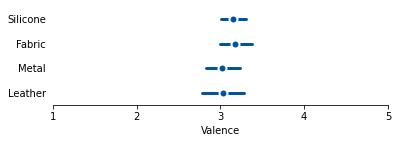

<Figure size 432x288 with 0 Axes>

In [54]:
plot_cis(material_valence_means_cis, filename="material_valence_ci", format='pdf', xLabel='Valence', showOnlyIntegers=True, xlim=(1,5))

##### Arousal

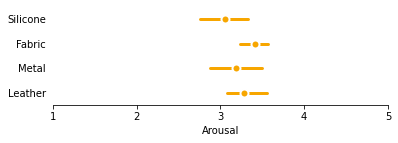

<Figure size 432x288 with 0 Axes>

In [55]:
plot_cis(material_arousal_means_cis, filename="material_arousal_ci", format='pdf', xLabel='Arousal', showOnlyIntegers=True, xlim=(1,5), color=orange)

#### Shape

##### Valence

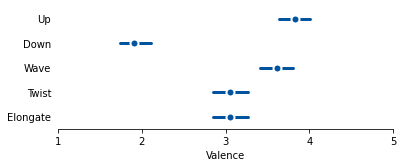

<Figure size 432x288 with 0 Axes>

In [56]:
plot_cis(shape_valence_means_cis, filename="shape_valence_ci", format='pdf', xLabel='Valence', showOnlyIntegers=True, xlim=(1,5), color=dark_blue)

#### Frequency

##### Valence

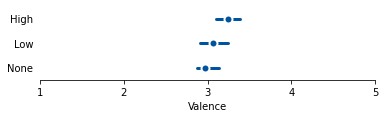

<Figure size 432x288 with 0 Axes>

In [57]:
plot_cis(frequency_valence_means_cis, filename="frequency_valence_ci", format='pdf', xLabel='Valence', showOnlyIntegers=True, xlim=(1,5), color=dark_blue)

##### Arousal

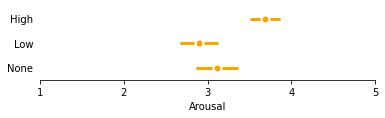

<Figure size 432x288 with 0 Axes>

In [58]:
plot_cis(frequency_arousal_means_cis, filename="frequency_arousal_ci", format='pdf', xLabel='Arousal', showOnlyIntegers=True, xlim=(1,5), color=orange)

#### Amplitude by Shape

##### Arousal

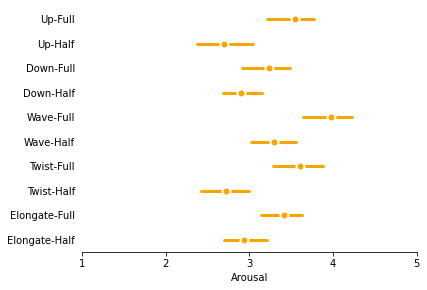

<Figure size 432x288 with 0 Axes>

In [59]:
plot_cis(amplitude_arousal_means_cis, filename="amplitude_arousal_ci", format='pdf', xLabel='Arousal', showOnlyIntegers=True, xlim=(1,5), color=orange)

#### Shape x Frequency

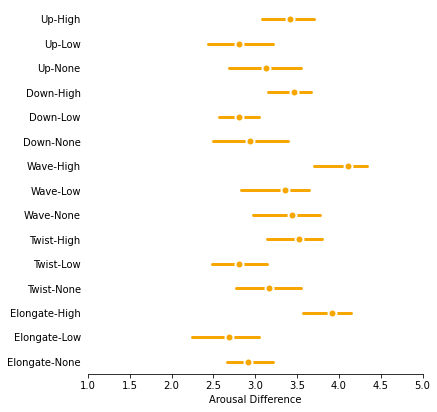

<Figure size 432x288 with 0 Axes>

In [60]:
plot_cis(
    shape_frequency_arousal_means_cis,
    point_estimate="Mean",
    filename="shape_frequency_arousal_means_cis",
    format='pdf',
    xLabel='Arousal Difference',
    showOnlyIntegers=False,
    color=orange,
    xlim=(1,5),
    showLineAtZero=True)

### Plot Mean Differences Confidence Intervals

#### Shape

##### Valence

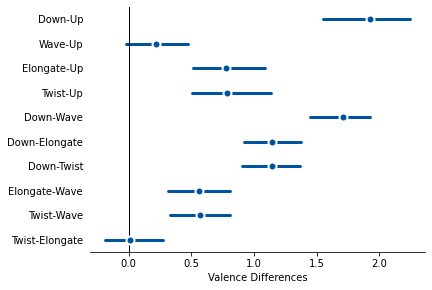

<Figure size 432x288 with 0 Axes>

In [61]:
plot_cis(
    shape_valence_differences_cis,
    point_estimate="Mean",
    filename="shape_valence_differences_cis",
    format='pdf',
    xLabel='Valence Differences',
    showOnlyIntegers=False,
    color=dark_blue,
    showLineAtZero=True)

#### Frequency

##### Valence

None vs Low

None vs High

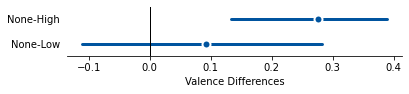

<Figure size 432x288 with 0 Axes>

In [62]:
plot_cis(
    frequency_valence_differences_cis,
    point_estimate="Mean",
    filename="frequency_valence_differences_cis",
    format='pdf',
    xLabel='Valence Differences',
    showOnlyIntegers=False,
    color=dark_blue,
    xlim=(None,None),
    showLineAtZero=True)

##### Arousal

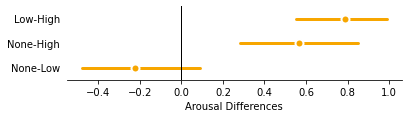

<Figure size 432x288 with 0 Axes>

In [63]:
plot_cis(
    frequency_arousal_differences_cis,
    point_estimate="Mean",
    filename="frequency_arousal_differences_cis",
    format='pdf',
    xLabel='Arousal Differences',
    showOnlyIntegers=False,
    color=orange,
    xlim=(None,None),
    showLineAtZero=True)

Decreasing of Arousal from None -> Low might be explainable (even if its low) with the tension of holding described by some participants. 

#### Amplitude

##### Arousal

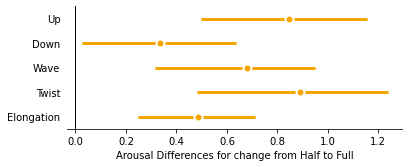

<Figure size 432x288 with 0 Axes>

In [64]:
plot_cis(
    amplitude_arousal_differences_cis,
    point_estimate="Mean",
    filename="amplitude_arousal_differences_cis",
    format='pdf',
    xLabel='Arousal Differences for change from Half to Full',
    showOnlyIntegers=False,
    color=orange,
    xlim=(None,None),
    showLineAtZero=True)